Columns available: ['ordernumber', 'quantityordered', 'priceeach', 'orderlinenumber', 'sales', 'orderdate', 'status', 'qtr_id', 'month_id', 'year_id', 'productline', 'msrp', 'productcode', 'customername', 'phone', 'addressline1', 'addressline2', 'city', 'state', 'postalcode', 'country', 'territory', 'contactlastname', 'contactfirstname', 'dealsize', 'cost_each', 'profit_est', 'discount_pct', 'inventory_age_days', 'is_profitable']

Model Performance:
ROC-AUC: 1.000 | F1: 1.000 | Precision@50 (loss picks): 0.080
Test set size: 56 | Profitable=52 | Loss=4

Top 10 flagged SKUs contribute ~INR 22,663 negative profit annually (test split).
📂 Exported Top 10 flagged SKUs to top10_loss_leading_skus.csv

Feature Importances (RandomForest):
avg_discount         0.635081
avg_price            0.139513
total_sales          0.093080
avg_inventory_age    0.058763
total_qty            0.042411
order_count          0.031153
dtype: float64


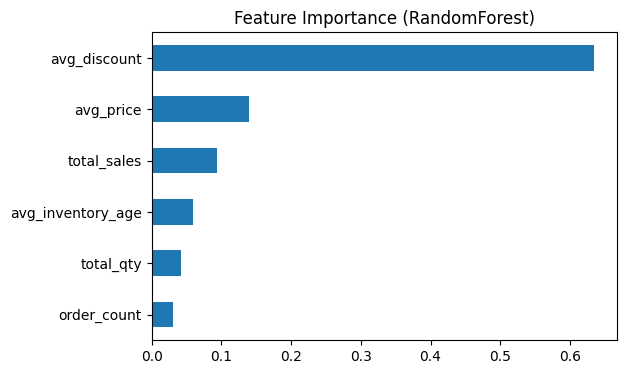


Permutation Importances (Validation-based):
avg_discount         0.108929
total_sales          0.010714
total_qty            0.000000
avg_price            0.000000
avg_inventory_age    0.000000
order_count          0.000000
dtype: float64


In [2]:
# CELL 1: Setup
import pandas as pd, numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, f1_score, precision_score
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

# Helper: Precision@K for "loss" class
def precision_at_k(y_true, y_scores, k=50):
    """Compute Precision@K for the 'loss' class (is_profitable=0)."""
    n = len(y_true)
    if n == 0:
        return np.nan
    k = min(k, n)
    order = np.argsort(-y_scores)  # rank by loss probability
    topk = order[:k]
    y_pred_loss = np.zeros_like(y_true)
    y_pred_loss[topk] = 1
    y_true_loss = (y_true == 0).astype(int)
    return precision_score(y_true_loss, y_pred_loss, zero_division=0)

# CELL 2: Load data & build SKU×Territory features
df = pd.read_csv("Data1/cleaned_sales.csv", parse_dates=["orderdate"])
df.columns = [c.lower() for c in df.columns]

print("Columns available:", df.columns.tolist())  # sanity check

agg = (df.groupby(["productcode","territory"], as_index=False)
         .agg(total_sales=("sales","sum"),
              total_qty=("quantityordered","sum"),
              avg_price=("priceeach","mean"),
              avg_discount=("discount_pct","mean"),
              avg_inventory_age=("inventory_age_days","mean"),
              total_profit=("profit_est","sum"),   # <-- FIXED
              order_count=("ordernumber","nunique")))

agg["is_profitable"] = (agg["total_profit"] > 0).astype(int)

features = ["total_sales","total_qty","avg_price","avg_discount","avg_inventory_age","order_count"]
X = agg[features].fillna(0)
y = agg["is_profitable"].values

# Edge case: only one class present
if len(np.unique(y)) < 2:
    print("⚠️ Only one class present (all profitable or all loss). Classification not possible.")
else:
    # CELL 3: Train/test split
    X_tr, X_te, y_tr, y_te, idx_tr, idx_te = train_test_split(
        X, y, agg.index.values, test_size=0.2, random_state=42, stratify=y
    )

    clf = RandomForestClassifier(
        n_estimators=400, max_depth=None, random_state=42, class_weight="balanced"
    )
    clf.fit(X_tr, y_tr)

    # Predictions
    proba_prof_te = clf.predict_proba(X_te)[:,1]  # P(profitable)

    # Metrics
    roc = roc_auc_score(y_te, proba_prof_te)
    f1 = f1_score(y_te, (proba_prof_te>0.5).astype(int))
    K = min(50, len(y_te))
    p_at_k = precision_at_k(y_te, 1 - proba_prof_te, k=K)

    print(f"\nModel Performance:")
    print(f"ROC-AUC: {roc:.3f} | F1: {f1:.3f} | Precision@{K} (loss picks): {p_at_k:.3f}")
    print(f"Test set size: {len(y_te)} | Profitable={y_te.sum()} | Loss={(y_te==0).sum()}")

    # CELL 4: Business impact quantification
    te_subset = agg.loc[idx_te].copy()
    te_subset = te_subset.assign(p_loss=(1 - proba_prof_te))
    flagged = te_subset.sort_values("p_loss", ascending=False).head(10)

    neg_profit_annual = (-flagged["total_profit"].clip(upper=0)).sum()
    print(f"\nTop 10 flagged SKUs contribute ~INR {neg_profit_annual:,.0f} negative profit annually (test split).")

    # Export flagged SKUs to CSV
    flagged.to_csv("top10_loss_leading_skus.csv", index=False)
    print("📂 Exported Top 10 flagged SKUs to top10_loss_leading_skus.csv")

    # CELL 5: Explainability via feature importances
    print("\nFeature Importances (RandomForest):")
    importances = pd.Series(clf.feature_importances_, index=features).sort_values(ascending=False)
    print(importances)

    # Plot feature importances
    plt.figure(figsize=(6,4))
    importances.plot(kind="barh", title="Feature Importance (RandomForest)")
    plt.gca().invert_yaxis()
    plt.show()

    # Permutation importance for validation-based check
    r = permutation_importance(clf, X_te, y_te, n_repeats=10, random_state=42)
    perm_importances = pd.Series(r.importances_mean, index=features).sort_values(ascending=False)
    print("\nPermutation Importances (Validation-based):")
    print(perm_importances)
